In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from deluca.agents import GPC
from deluca.envs import LDS
import jax
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [62]:
def loop(context, i):
    controller, state, A, B = context
    try:
        action = controller(state, A, B)
    except:
        action = controller(state)
        
    state = A @ state + B @ action + np.random.normal(0, 0.2, size=(n,1)) # gaussian noise

    if(i % T//2 == 0): # switch system
        A,B = jnp.array([[1.,1.5], [0,1.]]), jnp.array([[0],[0.9]])
    error = jnp.linalg.norm(state)+jnp.linalg.norm(action)
    return (controller, state, A, B), error

def get_errs(T, controller, A, B):
    state = jnp.zeros((n, 1))
    errs = [0.]
    
    for i in tqdm(range(1, T)):
        (controller, state, A, B), error = loop((controller, state, A, B), i)
        errs.append(error)
    
    return errs

# TODO: need to address problem of LQR with jax.lax.scan
def get_errs_scan(T, controller, A, B):
    state = jnp.zeros((n, 1))
    xs = jnp.array(jnp.arange(T))
    _, errs = jax.lax.scan(loop, (controller, state, A, B), xs)
    return errs

In [63]:
cummean = lambda x: np.cumsum(x)/(np.ones(T) + np.arange(T))
n, m = 2, 1
T = 600

100%|██████████| 599/599 [00:02<00:00, 215.61it/s]


GPC incurs  1.0159633663594827  loss under gaussian iid noise


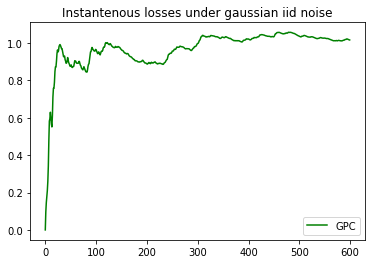

In [64]:
A,B = jnp.array([[1.,.5], [0,1.]]), jnp.array([[0],[1.2]])

gpc = GPC(A, B)

gpc_errs = get_errs(T, gpc, A, B)
# gpc_errs_scan = get_errs_scan(T, gpc, A, B)
print("GPC incurs ", np.mean(gpc_errs), " loss under gaussian iid noise")
# print("GPC with scan incurs ", np.mean(gpc_errs_scan), " loss under gaussian iid noise")


plt.title("Instantenous losses under gaussian iid noise")
plt.plot(cummean(gpc_errs), "green", label = "GPC")
plt.legend();